#### Libraries

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('UCI_Credit_Card.csv')
print(data.head)

<bound method NDFrame.head of           ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  \
0          1    20000.0    2          2         1   24      2      2     -1   
1          2   120000.0    2          2         2   26     -1      2      0   
2          3    90000.0    2          2         2   34      0      0      0   
3          4    50000.0    2          2         1   37      0      0      0   
4          5    50000.0    1          2         1   57     -1      0     -1   
...      ...        ...  ...        ...       ...  ...    ...    ...    ...   
29995  29996   220000.0    1          3         1   39      0      0      0   
29996  29997   150000.0    1          3         2   43     -1     -1     -1   
29997  29998    30000.0    1          2         2   37      4      3      2   
29998  29999    80000.0    1          3         1   41      1     -1      0   
29999  30000    50000.0    1          2         1   46      0      0      0   

       PAY_4  ...  BI

In [ ]:
print(data.head())

In [21]:
print(pd.isna(data).sum())

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64


In [3]:
# 3. Define features (X) and target (y)
X = data.drop("default.payment.next.month", axis=1)  # features
y = data["default.payment.next.month"]               # target

### Feature Engineering

In [16]:
# -----------------------------
# Feature Engineering
# -----------------------------

# 1. Credit Utilization (current debt as % of credit limit)
# Using last month's bill amount (BILL_AMT1)
data["credit_utilization"] = data["BILL_AMT1"] / (data["LIMIT_BAL"] + 1)  # +1 avoids divide by zero

# 2. Payment Ratio (last payment / last bill)
data["payment_ratio"] = data["PAY_AMT1"] / (data["BILL_AMT1"] + 1)

# 3. Average Payment Ratio (over 6 months)
bill_cols = ["BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6"]
pay_cols  = ["PAY_AMT1","PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6"]

data["avg_payment_ratio"] = (data[pay_cols].sum(axis=1)) / (data[bill_cols].sum(axis=1) + 1)

# 4. Total Bill & Total Payment (last 6 months)
data["total_bill_amt"] = data[bill_cols].sum(axis=1)
data["total_pay_amt"]  = data[pay_cols].sum(axis=1)

# 5. Payment to Credit Limit Ratio
data["payment_to_limit"] = data["total_pay_amt"] / (data["LIMIT_BAL"] + 1)

# 6. Missed Payments Count (based on repayment status PAY_0 to PAY_6)
pay_status_cols = ["PAY_0","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6"]
data["missed_payments"] = (data[pay_status_cols] > 0).sum(axis=1)

# 7. Age Group (categorical binning)
data["age_group"] = pd.cut(data["AGE"], bins=[20,30,40,50,60,70,100],
                           labels=["20s","30s","40s","50s","60s","70+"])

# -----------------------------
# Final dataset ready for ML
# -----------------------------

print(data[["LIMIT_BAL","BILL_AMT1","PAY_AMT1","credit_utilization","payment_ratio",
            "avg_payment_ratio","missed_payments","age_group"]].head())


   LIMIT_BAL  BILL_AMT1  PAY_AMT1  credit_utilization  payment_ratio  \
0    20000.0     3913.0       0.0            0.195640       0.000000   
1   120000.0     2682.0       0.0            0.022350       0.000000   
2    90000.0    29239.0    1518.0            0.324874       0.051915   
3    50000.0    46990.0    2000.0            0.939781       0.042561   
4    50000.0     8617.0    2000.0            0.172337       0.232072   

   avg_payment_ratio  missed_payments age_group  
0           0.089422                2       20s  
1           0.292774                2       20s  
2           0.108387                0       30s  
3           0.036259                0       30s  
4           0.540049                0       50s  


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
# 5. Train logistic regression model
model = LogisticRegression()  # max_iter increased for convergence
model.fit(X_train, y_train)

C:\Users\Hp\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [9]:
# 6. Make predictions
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]  # probability of class 1

In [11]:
# 7. Evaluate model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Confusion Matrix:
[[7040    0]
 [1960    0]]


In [12]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      7040
           1       0.00      0.00      0.00      1960

    accuracy                           0.78      9000
   macro avg       0.39      0.50      0.44      9000
weighted avg       0.61      0.78      0.69      9000



C:\Users\Hp\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Hp\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Hp\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

In [13]:
# ROC-AUC
auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC Score:", auc)

ROC-AUC Score: 0.6414223388218925


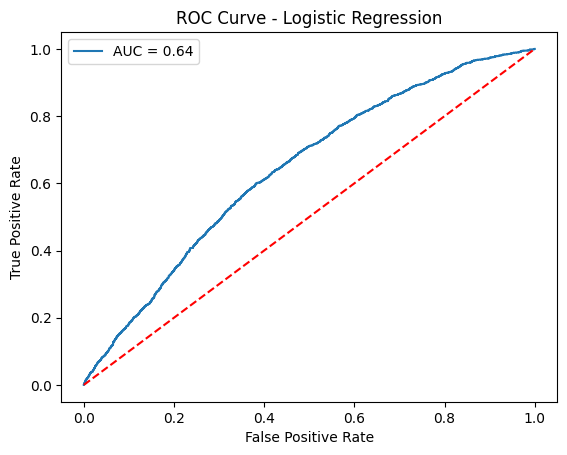

In [14]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="red")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()